# A Hybrid Approach of Fuzzy Logic and Neural Networks for Diabetes Prediction

## Setup and Imports

In [1]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# Metrics and Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    average_precision_score
)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Additional Scientific Computing
import skfuzzy as fuzz
from scipy import stats

# Set Random Seeds for Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

C:\Users\arjun\AppData\Local\Temp\ipykernel_11688\918722243.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. Data Loading and Initial Exploration

In [2]:
diabetes_data = pd.read_csv('diabetes.csv')

# Display Basic Information
print("Dataset Shape:", diabetes_data.shape)
print("\nColumn Information:")
print(diabetes_data.info())

# Basic Statistical Summary
print("\nDescriptive Statistics:")
print(diabetes_data.describe())

# Class Distribution
print("\nClass Distribution:")
print(diabetes_data['Outcome'].value_counts(normalize=True))

Dataset Shape: (768, 9)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Descriptive Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.8

## 2. Exploratory Data Analysis (EDA)

### 2.1 Distribution Analysis

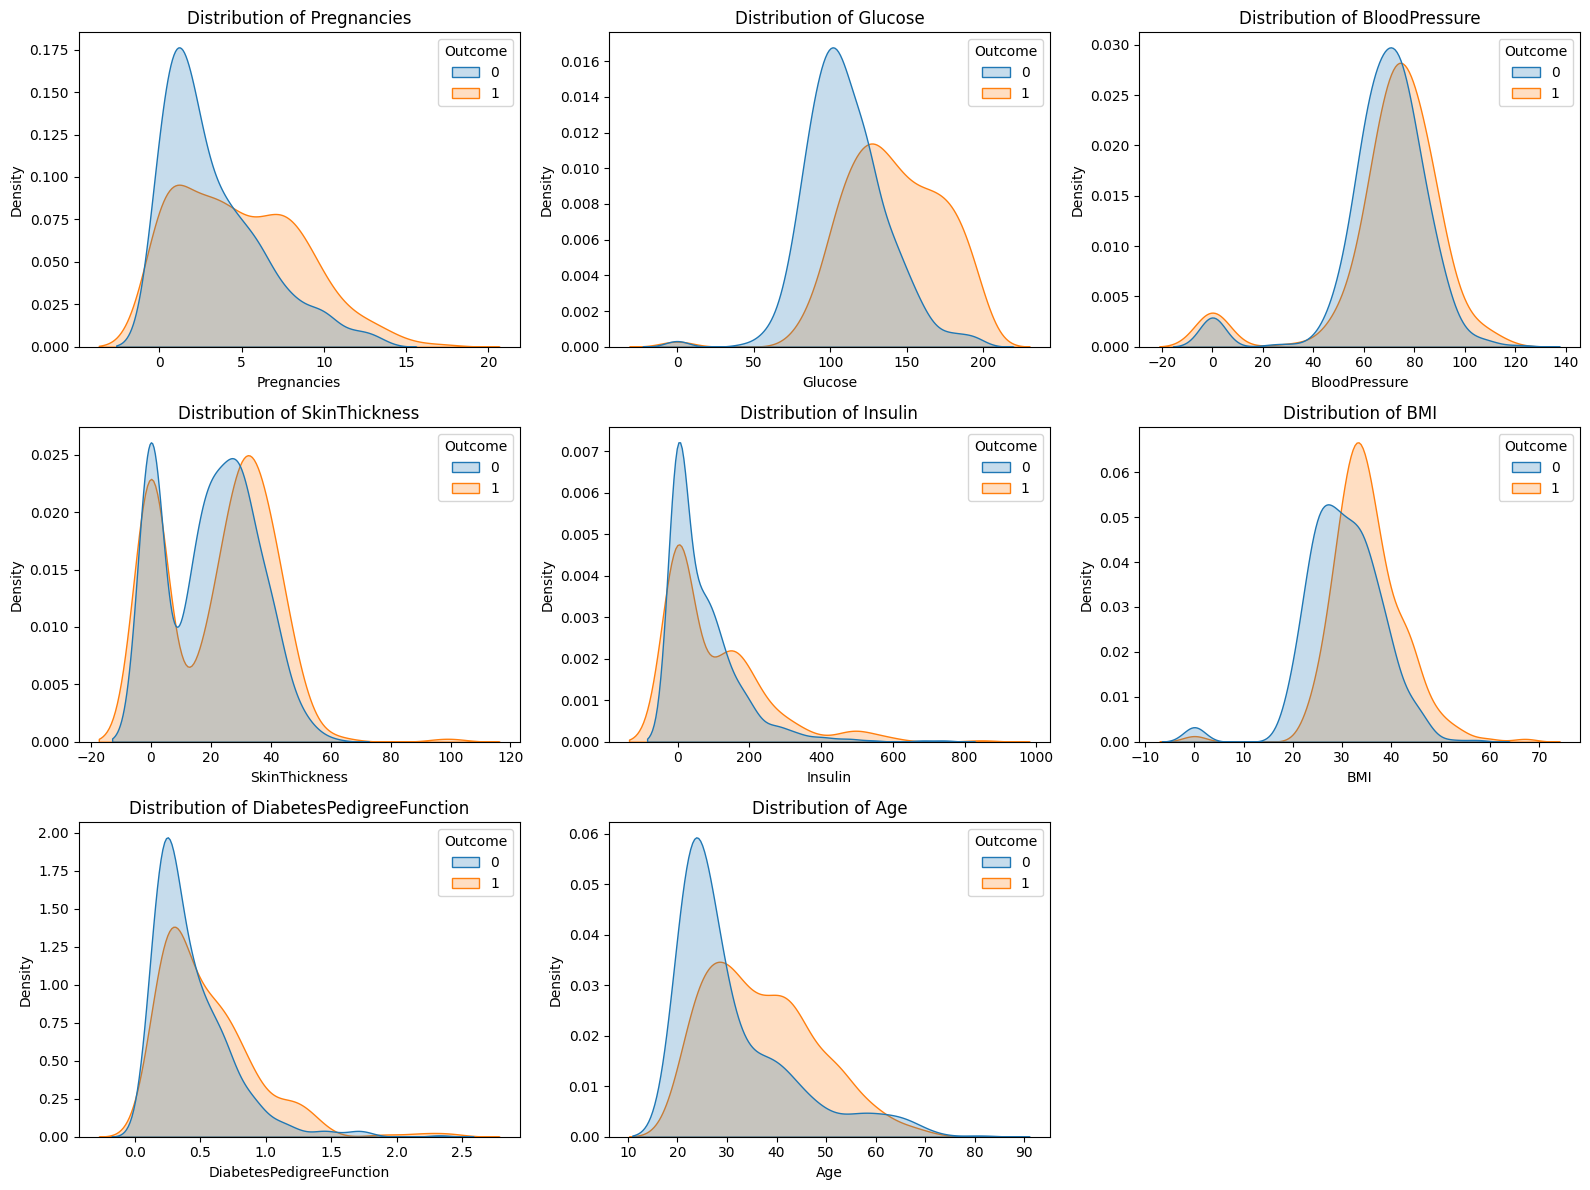

In [3]:
plt.figure(figsize=(16, 12))
features = diabetes_data.columns.drop('Outcome')

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    
    # Kernel Density Estimation
    sns.kdeplot(
        data=diabetes_data, 
        x=feature, 
        hue='Outcome', 
        fill=True, 
        common_norm=False
    )
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

### 2.2 Statistical Significance Tests

In [4]:
print("Feature Significance Tests:")
for feature in features:
    diabetic = diabetes_data[diabetes_data['Outcome'] == 1][feature]
    non_diabetic = diabetes_data[diabetes_data['Outcome'] == 0][feature]
    t_stat, p_value = stats.ttest_ind(diabetic, non_diabetic)
    print(f"{feature}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

Feature Significance Tests:
Pregnancies: t-statistic = 6.2984, p-value = 0.0000
Glucose: t-statistic = 14.6001, p-value = 0.0000
BloodPressure: t-statistic = 1.8047, p-value = 0.0715
SkinThickness: t-statistic = 2.0747, p-value = 0.0383
Insulin: t-statistic = 3.6443, p-value = 0.0003
BMI: t-statistic = 8.4718, p-value = 0.0000
DiabetesPedigreeFunction: t-statistic = 4.8858, p-value = 0.0000
Age: t-statistic = 6.7927, p-value = 0.0000


### 2.3 Correlation Analysis

<Figure size 1200x1000 with 0 Axes>

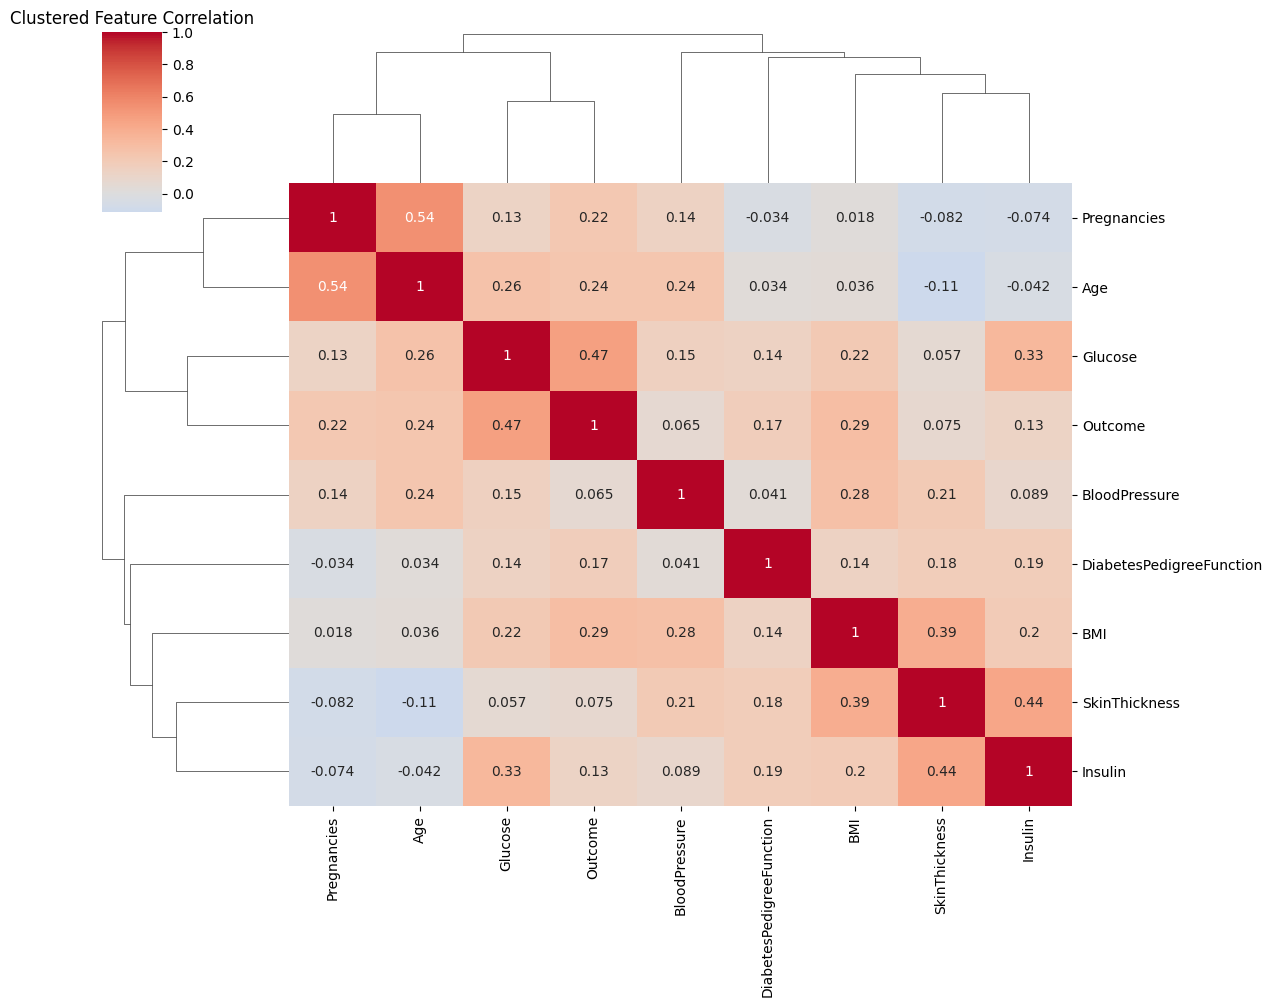

In [5]:
plt.figure(figsize=(12, 10))
correlation_matrix = diabetes_data.corr()

# Clustered Heatmap
sns.clustermap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0, 
    figsize=(12, 10)
)
plt.title('Clustered Feature Correlation')
plt.show()

## 3. Data Preprocessing

### 3.1 Data Cleaning and Feature Engineering

In [6]:
df = diabetes_data.copy()

# Handle Zero Values and Outliers
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in zero_columns:
    # Winsorization
    p05, p95 = np.percentile(df[df[col] > 0][col], [5, 95])
    df.loc[(df[col] == 0) | (df[col] < p05), col] = p05
    df.loc[df[col] > p95, col] = p95

# Feature Engineering
df['BMI_Age_Interaction'] = df['BMI'] * df['Age']
df['Glucose_Insulin_Ratio'] = df['Glucose'] / (df['Insulin'] + 1)

# Prepare Features and Target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

C:\Users\arjun\AppData\Local\Temp\ipykernel_11688\274921076.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '41.650000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[col] == 0) | (df[col] < p05), col] = p05


### 3.2 Outlier Detection

In [7]:
def detect_outliers_iqr(data, factor=1.5):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return (data < lower_bound) | (data > upper_bound)

# Detect outliers across numerical columns
numerical_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                     'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

outliers_summary = {}
for column in numerical_columns:
    outliers = detect_outliers_iqr(diabetes_data[column])
    outliers_summary[column] = outliers.sum()

print("Outliers in each feature:")
for col, count in outliers_summary.items():
    print(f"{col}: {count} outliers")

Outliers in each feature:
Pregnancies: 4 outliers
Glucose: 5 outliers
BloodPressure: 45 outliers
SkinThickness: 1 outliers
Insulin: 34 outliers
BMI: 19 outliers
DiabetesPedigreeFunction: 29 outliers
Age: 9 outliers


### 3.3 Feature Selection

In [8]:
# Statistical Feature Selection
selector = SelectKBest(score_func=f_classif, k=6)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()
print("Selected Features:", selected_features)

Selected Features: ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'BMI_Age_Interaction']


### 3.4 Scaling and Dimensionality Reduction

In [9]:
# Advanced Scaling
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X_selected)

# Dimensionality Reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_reduced = pca.fit_transform(X_scaled)

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)

## 4. Fuzzy Membership Functions

In [10]:
# 4. Update Fuzzy Membership Function Creation
def create_fuzzy_membership_features(X, features):
    fuzzy_features = []
    for feature in features:
        values = X[feature].values
        
        # Define fuzzy universe for the feature
        universe = np.linspace(values.min(), values.max(), 100)
        
        # Create membership functions
        low = fuzz.trimf(universe, [universe.min(), universe.min(), universe.mean()])
        medium = fuzz.trimf(universe, [universe.min(), universe.mean(), universe.max()])
        high = fuzz.trimf(universe, [universe.mean(), universe.max(), universe.max()])
        
        # Calculate membership values
        low_membership = fuzz.interp_membership(universe, low, values)
        medium_membership = fuzz.interp_membership(universe, medium, values)
        high_membership = fuzz.interp_membership(universe, high, values)
        
        # Append fuzzy features
        fuzzy_features.append(low_membership)
        fuzzy_features.append(medium_membership)
        fuzzy_features.append(high_membership)
    
    # Stack fuzzy features and return as DataFrame
    fuzzy_features = np.vstack(fuzzy_features).T
    fuzzy_feature_names = [f"{feature}_{lvl}" for feature in features for lvl in ['low', 'medium', 'high']]
    return pd.DataFrame(fuzzy_features, columns=fuzzy_feature_names)

# Add Fuzzy Membership Features to X
fuzzy_features = create_fuzzy_membership_features(df, ['Glucose', 'BMI', 'Age'])
X_fuzzy = pd.concat([X.reset_index(drop=True), fuzzy_features.reset_index(drop=True)], axis=1)

# Re-apply scaling and dimensionality reduction with extended features
X_scaled_fuzzy = std_scaler.fit_transform(X_fuzzy)
X_reduced_fuzzy = pca.fit_transform(X_scaled_fuzzy)

# Stratified Train-Test Split
X_train_fuzzy, X_test_fuzzy, y_train_fuzzy, y_test_fuzzy = train_test_split(
    X_reduced_fuzzy, y, test_size=0.2, stratify=y, random_state=42
)

## 5. Fuzzy Neural Network (FNN) Model

In [11]:
# 5. Modify Neural Network to Handle Extended Input
def build_fuzzy_model(input_shape):
    model = keras.Sequential([
        layers.Dense(
            64, 
            activation='swish',
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            input_shape=(input_shape,)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(
            32, 
            activation='swish',
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(
            16, 
            activation='relu',
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
        ),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = optimizers.Adam(
        learning_rate=1e-3, 
        beta_1=0.9, 
        beta_2=0.999
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy', 
            keras.metrics.Precision(), 
            keras.metrics.Recall()
        ]
    )
    
    return model

fuzzy_model = build_fuzzy_model(X_train_fuzzy.shape[1])

c:\Users\arjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 6. Model Training

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-5
)

checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_accuracy', 
    save_best_only=True
)

In [13]:
# Train the Fuzzy Neural Model
history_fuzzy = fuzzy_model.fit(
    X_train_fuzzy, y_train_fuzzy,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6054 - loss: 0.7749 - precision: 0.3503 - recall: 0.1951 - val_accuracy: 0.7642 - val_loss: 0.6412 - val_precision: 0.6829 - val_recall: 0.6364 - learning_rate: 0.0010
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6888 - loss: 0.5783 - precision: 0.5619 - recall: 0.3828 - val_accuracy: 0.7886 - val_loss: 0.5907 - val_precision: 0.6875 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7111 - loss: 0.5996 - precision: 0.5950 - recall: 0.4463 - val_accuracy: 0.7967 - val_loss: 0.5526 - val_precision: 0.6792 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7475 - loss: 0.5401 - precision: 0.6679 - recall: 0.5172 - val_accuracy: 0.7886 - val_loss: 0.5267 - val_precision: 0.6667 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.73

## 7. Model Evaluation

In [14]:
# Evaluate the model on the test set
fuzzy_eval = fuzzy_model.evaluate(X_test_fuzzy, y_test_fuzzy, verbose=1)
print(f"Fuzzy Neural Model Performance: {fuzzy_eval}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7446 - loss: 0.5077 - precision: 0.6272 - recall: 0.7119
Fuzzy Neural Model Performance: [0.492550790309906, 0.7597402334213257, 0.6393442749977112, 0.7222222089767456]


### 7.1 Performance Metrics

In [15]:
# Predictions
y_pred_proba = fuzzy_model.predict(X_test_fuzzy)
y_pred = (y_pred_proba > 0.5).astype(int)

# Classification Report
print("\n--- Detailed Model Performance ---")
print(classification_report(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

--- Detailed Model Performance ---
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       100
           1       0.64      0.72      0.68        54

    accuracy                           0.76       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.76      0.76       154



### 7.2 Visualization of Results

Training History

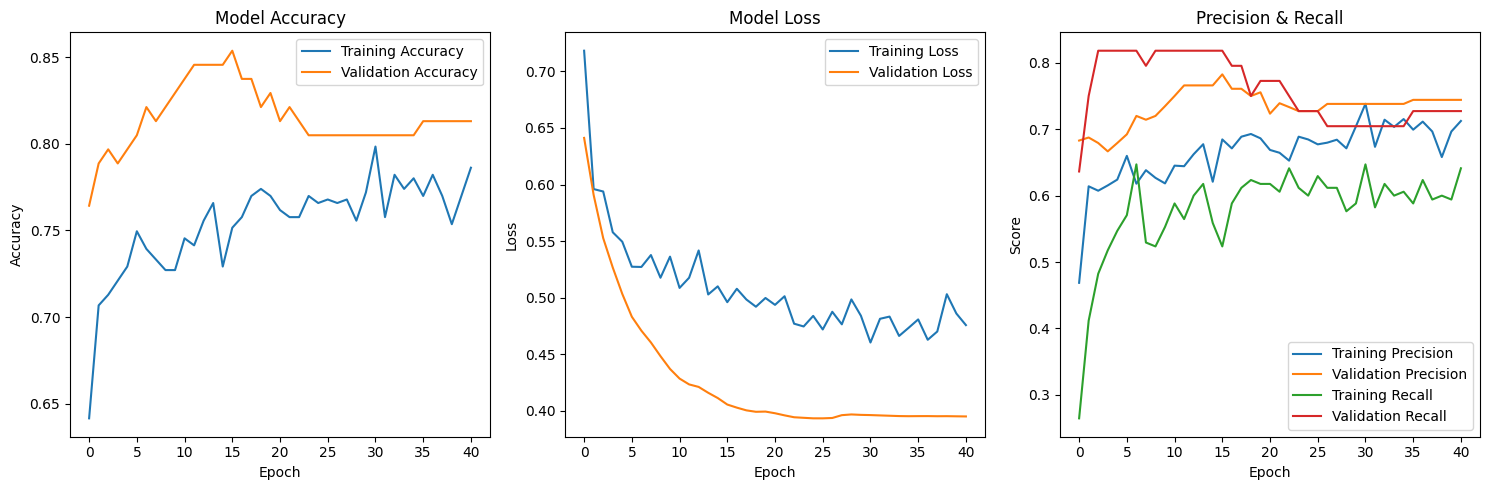

In [16]:
plt.figure(figsize=(15, 5))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(history_fuzzy.history['accuracy'], label='Training Accuracy')
plt.plot(history_fuzzy.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 3, 2)
plt.plot(history_fuzzy.history['loss'], label='Training Loss')
plt.plot(history_fuzzy.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precision and Recall
plt.subplot(1, 3, 3)
plt.plot(history_fuzzy.history['precision'], label='Training Precision')
plt.plot(history_fuzzy.history['val_precision'], label='Validation Precision')
plt.plot(history_fuzzy.history['recall'], label='Training Recall')
plt.plot(history_fuzzy.history['val_recall'], label='Validation Recall')
plt.title('Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

ROC Curve, Confusion Matrix and Precision-Recall Curve

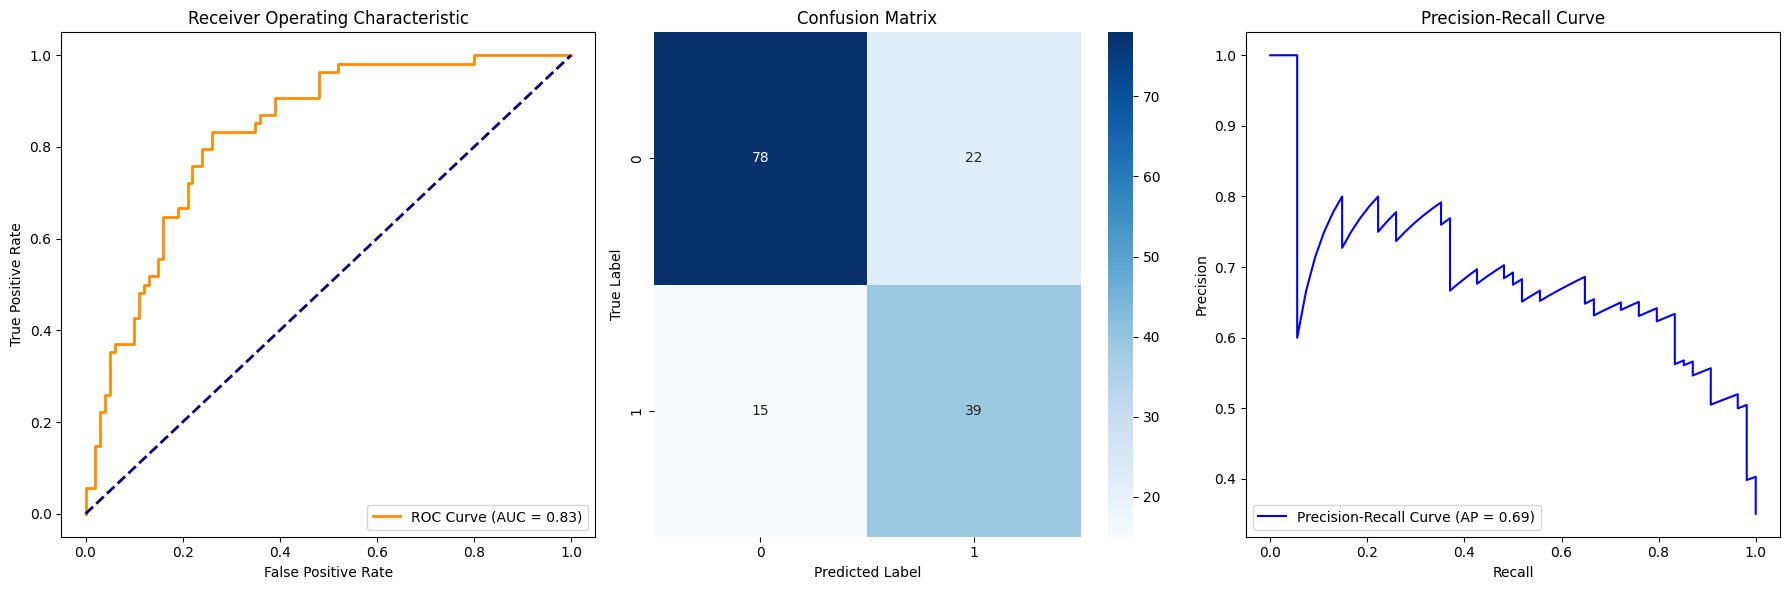

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

cm = confusion_matrix(y_test, (y_pred_proba > 0.5).astype(int))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# ROC Curve
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc="lower right")

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Confusion Matrix')
axs[1].set_xlabel('Predicted Label')
axs[1].set_ylabel('True Label')

# Precision-Recall Curve
axs[2].plot(recall, precision, color='blue', label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
axs[2].set_title('Precision-Recall Curve')
axs[2].set_xlabel('Recall')
axs[2].set_ylabel('Precision')
axs[2].legend(loc="lower left")

plt.tight_layout()
plt.show()